#1 - Implementing the model





In [95]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import torch.nn.functional as F

from fastai.data.external import untar_data, URLs
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = True

Loading images

In [96]:
#!pip install fastai --upgrade

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Initial Working Directory: /content/drive/My Drive
Directory contents:  ['Comp. Tools Data Science', 'Colab Notebooks', 'data', 'runs', 'events.out.tfevents.1700167182.b7687c2f0442.173.1', 'model_epoch200_fulldataset.pt']
Checking existence  None


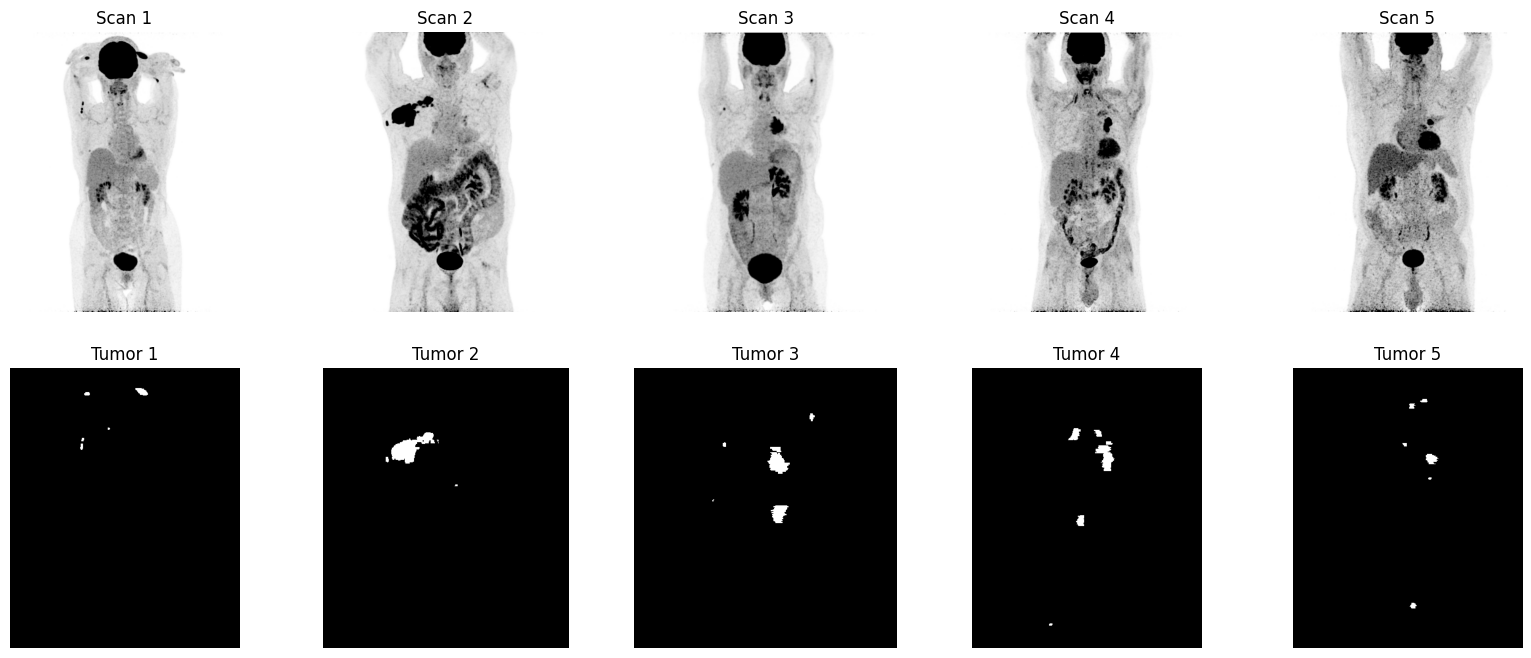

In [98]:
import os

current_directory = os.getcwd()
print("Initial Working Directory:", current_directory)
print("Directory contents: ", os.listdir())
print("Checking existence ",os.chdir(r'/content/drive/MyDrive'))
#CHANGE TO YOUR DIRECTORY
image_path = r'/content/drive/MyDrive/data/patients/imgs'
control_path = r'/content/drive/MyDrive/data/controls/imgs'
segmentation_path =r'/content/drive/MyDrive/data/patients/labels'



image_files = sorted(os.listdir(image_path))[:5]
segmentation_files = sorted(os.listdir(segmentation_path))[:5]
#first to train on small number to see if all works
#train_paths = sorted(os.listdir(image_path))[:50]
#val_paths = sorted(os.listdir(image_path))[50:]
# Iterate over the first five files and display the images and segmentations
i = 1
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for image_file, segmentation_file in zip(image_files, segmentation_files):
    image_file_path = os.path.join(image_path, image_file)
    segmentation_file_path = os.path.join(segmentation_path, segmentation_file)

    # Load and display the image
    img = Image.open(image_file_path)
    plt.subplot(2, 5, image_files.index(image_file) + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Scan {i}')

    # Load and display the segmentation mask
    seg_mask = Image.open(segmentation_file_path).convert("L")
    plt.subplot(2, 5, 5 + image_files.index(image_file) + 1)
    plt.imshow(seg_mask, cmap='gray')
    plt.axis('off')
    plt.title(f'Tumor {i}')

    i +=1

plt.show()


In [99]:
from sklearn.model_selection import train_test_split

class TumorDataset(Dataset):
    def __init__(self, image_dir, segmentation_dir, controls_dir, transform=None):
        self.image_dir = image_dir
        self.controls_dir = controls_dir
        self.segmentation_dir = segmentation_dir
        self.transform = transform

        self.image_filenames = sorted(os.listdir(image_dir)) + sorted(os.listdir(controls_dir))
        self.segmentation_filenames = sorted(os.listdir(segmentation_dir))
        num_additional_images = len(self.image_filenames) - len(self.segmentation_filenames)
        new_segmentation_filenames = []

        for i in range(num_additional_images):
            black_image = np.zeros((256, 256), dtype=np.uint8)  # Assuming grayscale
            image_filename = f"segmentation_{i + num_additional_images+1}.png"
            image_path = os.path.join(segmentation_dir, image_filename)
            Image.fromarray(black_image).save(image_path)
            new_segmentation_filenames.append(image_filename)
        self.segmentation_filenames.extend(new_segmentation_filenames)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        if filename in os.listdir(self.image_dir):
            image_path = os.path.join(self.image_dir, filename)
        else:
            image_path = os.path.join(self.controls_dir, filename)
        segmentation_path = os.path.join(self.segmentation_dir, self.segmentation_filenames[idx])

        image = Image.open(image_path).convert('L')  # Convert to grayscale
        segmentation = Image.open(segmentation_path).convert('L')

        if self.transform:
            image = self.transform(image)
            segmentation = self.transform(segmentation)

        return {'ct_scan': image, 'tumor_mask': segmentation}

def custom_collate(batch):
    # Resize images and masks to a common size
    batch_size = len(batch)
    max_height = max(item['ct_scan'].shape[1] for item in batch)
    max_width = max(item['ct_scan'].shape[2] for item in batch)

    # Pad images and masks to the maximum size
    padded_images = [torch.nn.functional.pad(item['ct_scan'], pad=(0, max_width - item['ct_scan'].shape[2], 0, max_height - item['ct_scan'].shape[1])) for item in batch]
    padded_masks = [torch.nn.functional.pad(item['tumor_mask'], pad=(0, max_width - item['tumor_mask'].shape[2], 0, max_height - item['tumor_mask'].shape[1])) for item in batch]

    # Stack padded images and masks
    stacked_images = torch.stack(padded_images)
    stacked_masks = torch.stack(padded_masks)

    return {'ct_scan': stacked_images, 'tumor_mask': stacked_masks}

# Define your data transformation (adjust as needed)
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

# Define your dataset instance
dataset = TumorDataset(image_dir=image_path, segmentation_dir=segmentation_path, controls_dir=control_path, transform=transform)

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, train_size=0.75, random_state=42)

# Define batch size
batch_size = 32 # Adjust as needed

# Create data loaders with the custom collate function
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=custom_collate)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate)

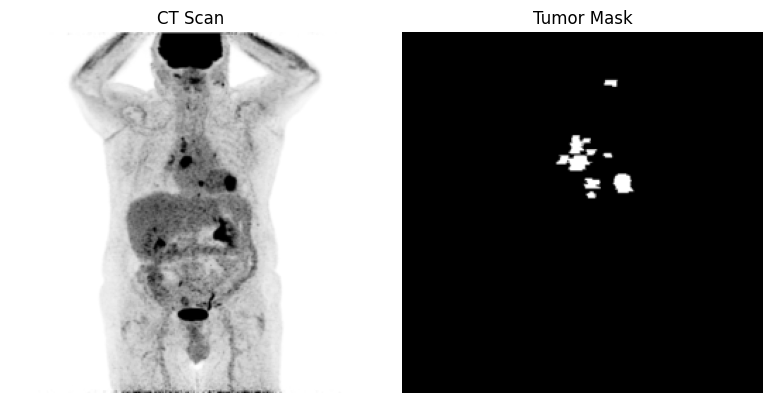

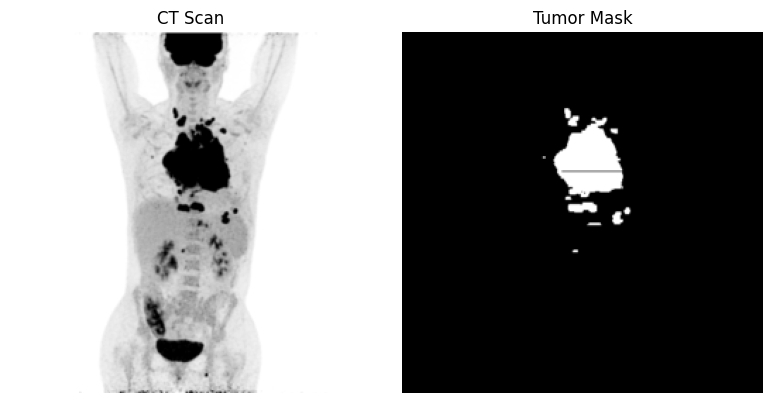

In [100]:


# Visualize the CT scans and their labels
for idx in range(100,102):
    data = dataset[idx]  # Get the data at the sampled index
    ct_scan = data['ct_scan'].squeeze(0)  # Extract the CT scan
    tumor_mask = data['tumor_mask'].squeeze(0)  # Extract the tumor mask

    # Convert to NumPy arrays if needed (assuming they are PIL images)
    ct_scan = np.array(ct_scan)
    tumor_mask = np.array(tumor_mask)

    # Plotting CT scan
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(ct_scan, cmap='gray')
    plt.title('CT Scan')
    plt.axis('off')

    # Plotting tumor mask
    plt.subplot(1, 2, 2)
    plt.imshow(tumor_mask, cmap='gray')
    plt.title('Tumor Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [101]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, activation=None ):
        super(ConvLayer, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),nn.LeakyReLU(0.2, inplace=True)
        ]
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class TransposeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, flag, kernel_size=4, stride=2, padding=1, bias=False):
        super(TransposeConvLayer, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels)
        ]
        if flag == 1:
            layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)


class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        super(UnetBlock, self).__init__()
        self.outermost = outermost
        if input_c is None:
            input_c = nf
        downconv = ConvLayer(input_c, ni)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(inplace=True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = TransposeConvLayer(ni * 2, nf//2, flag = 1)
            down = [downconv]
            up = [upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = TransposeConvLayer(ni, nf, bias=False, flag = 0)
            down = [downconv]
            up = [upconv, upnorm]
            model = down + up
        else:
            upconv = TransposeConvLayer(ni * 2, nf, bias=False, flag = 0)
            down = [downconv, downnorm]
            up = [upconv, upnorm]
            if dropout:
                up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
        self.residual = nn.Sequential(
            nn.Conv2d(input_c, nf, kernel_size=1, stride=1),
            nn.BatchNorm2d(nf)
        )

    def forward(self, x):

        if self.outermost:
            output = self.model(x)
            return output
        else:
            x_clone = x.clone()
            residual_output = self.residual(x_clone)
            model_output = self.model(x)
            concatenated_output = torch.cat([residual_output, model_output], 1)
            return concatenated_output


class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=1, n_down=8, num_filters=64):
        super(Unet, self).__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        x = (0.5 - 1e-7) * torch.erf(self.model(x)/torch.sqrt(torch.tensor(2)))
        return x


##Weights
We are going to initialize the weights of our model with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters in the article

In [102]:
def init_weights(net, init='norm', gain=0.1, print_message=True):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

        if 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    if print_message:
        print(f"model initialized with {init} initialization")
    return net

def init_model(model, device, init_type='norm', gain=0.02):
    model = model.to(device)
    model = init_weights(model, init=init_type, gain=gain)
    return model


## Dice Loss

In [103]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 1e-6  # Smoothing value to prevent division by zero
        input_flat = input.view(-1)
        target_flat = target.view(-1)
        intersection = (input_flat * target_flat).sum()
        dice_coeff = (2.0 * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)
        dice_loss = 1.0 - dice_coeff
        return dice_loss


## Main model

In [131]:
import torch.nn.functional as F
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=1e-2,
                 beta1=0.9, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=32), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))

        self.LossFunction = DiceLoss()  # Change loss function for segmentation

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.ct_scan = data['ct_scan'].to(self.device)
        self.tumor_mask = data['tumor_mask'].to(self.device)

    def forward(self):

        self.predicted_tumor_mask = self.net_G(self.ct_scan)
        '''
        predicted_mask_np = self.predicted_tumor_mask.detach().cpu().numpy()  # Detach if on GPU and move to CPU
        if len(predicted_mask_np.shape) == 4:  # Remove batch dimension if present
            predicted_mask_np = predicted_mask_np[0]

        # Plot the predicted mask (assuming it's a binary mask)
        predicted_mask_np = predicted_mask_np.squeeze(0)
        plt.imshow(predicted_mask_np, cmap='gray')  # Adjust the colormap based on your mask
        plt.title('Predicted Tumor Mask')
        plt.colorbar()
        plt.show()
        print(self.tumor_mask.shape)
        mask_np = self.tumor_mask.detach().cpu().numpy()  # Detach if on GPU and move to CPU

        # Plot the predicted mask (assuming it's a binary mask)
        mask_np = np.squeeze(mask_np, axis=1)
        print(mask_np.shape)
        plt.imshow(mask_np[0], cmap='gray')  # Adjust the colormap based on your mask
        plt.title('Actual Tumor Mask')
        plt.colorbar()
        plt.show()
        '''
    def backward_G(self):
        predicted_flat = self.predicted_tumor_mask.view(-1)  # Flatten predicted tensor
        target_flat = self.tumor_mask.view(-1)  # Flatten target tensor

        self.seg_loss = self.LossFunction(predicted_flat,target_flat)
        self.total_loss = self.seg_loss * self.lambda_L1

        #print("Total Loss:", self.total_loss.item())

        #self.opt_G.zero_grad()
        self.total_loss.backward()
        self.opt_G.step()

    def optimize(self):
        self.forward()
        self.opt_G.zero_grad()
        self.net_G.train()
        self.backward_G()
        self.opt_G.step()



The MeasureClass class is a utility class for computing and tracking the average of a value over multiple iterations. It keeps track of the count, sum, and average of the values. The reset method resets the meter, while the update method updates the meter with a new value and count.



## Measures

In [105]:
#pip install tensorboard

In [132]:
from torch.utils.tensorboard import SummaryWriter

class MeasureClass:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    total_loss = MeasureClass()

    return {
            'total_loss': total_loss}

def update_losses(model, loss_meter_dict, count, writer, step):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
        writer.add_scalar(loss_name, loss_meter.avg, step)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)


def log_results(loss_meter_dict, step, writer):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")
        writer.add_scalar(loss_name, loss_meter.avg, step)

##1.8- Training function


In [133]:
def train_model(model, train_dl, val_dl, epochs, display_every=200):
    #val_data = next(iter(val_dl))
    writer = SummaryWriter()
    step = 0
    for epoch in range(1, epochs + 1):
        loss_meter_dict = create_loss_meters()
        i = 0

        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['ct_scan'].size(0), writer=writer, step=step)
            i += 1
            step += 1

            log_results(loss_meter_dict, step, writer)
        print('Epoch ', epoch)
        if epoch == 200:
          epoch_filename = f"model_epoch{epoch}_fulldataset.pt"
          torch.save(model.state_dict(), epoch_filename)
          print(f"Saved weights of epoch {epoch} to {epoch_filename}")

    writer.close()

# Assuming train_dl and val_dl are your training and validation data loaders
model = MainModel()
train_model(model, train_dl, val_dl, epochs=150)


model initialized with norm initialization


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 99.21072
total_loss: 98.11290
total_loss: 96.78538
total_loss: 97.05417
total_loss: 97.17433
total_loss: 97.05313
total_loss: 96.10691
total_loss: 96.16506
total_loss: 96.11199
total_loss: 95.81072
total_loss: 94.63973
total_loss: 94.89174
total_loss: 94.23262
total_loss: 94.03527
total_loss: 93.94419
Epoch  1


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 95.03375
total_loss: 94.73669
total_loss: 94.40816
total_loss: 93.83377
total_loss: 92.86057
total_loss: 91.27779
total_loss: 89.98595
total_loss: 89.58080
total_loss: 89.96648
total_loss: 90.44449
total_loss: 90.45893
total_loss: 90.48569
total_loss: 90.56045
total_loss: 90.73763
total_loss: 90.73755
Epoch  2


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 91.61063
total_loss: 91.56310
total_loss: 92.27090
total_loss: 91.25061
total_loss: 90.55161
total_loss: 88.93356
total_loss: 88.35687
total_loss: 87.35696
total_loss: 88.26934
total_loss: 88.62773
total_loss: 88.12224
total_loss: 88.24069
total_loss: 87.89375
total_loss: 88.29929
total_loss: 88.44562
Epoch  3


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 91.47144
total_loss: 85.72029
total_loss: 85.35105
total_loss: 87.33864
total_loss: 86.65835
total_loss: 87.57327
total_loss: 86.56976
total_loss: 85.23922
total_loss: 85.91266
total_loss: 86.88751
total_loss: 86.70687
total_loss: 87.27650
total_loss: 86.21517
total_loss: 85.90080
total_loss: 85.94790
Epoch  4


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 91.72231
total_loss: 85.24553
total_loss: 86.11698
total_loss: 87.39890
total_loss: 86.07290
total_loss: 84.94867
total_loss: 83.83230
total_loss: 84.10244
total_loss: 83.79186
total_loss: 82.28857
total_loss: 81.85980
total_loss: 81.67628
total_loss: 81.25725
total_loss: 80.62196
total_loss: 80.67271
Epoch  5


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 87.46292
total_loss: 81.58674
total_loss: 79.51640
total_loss: 77.47605
total_loss: 77.33856
total_loss: 78.21016
total_loss: 79.52322
total_loss: 79.90989
total_loss: 80.31176
total_loss: 80.29210
total_loss: 79.65612
total_loss: 79.52217
total_loss: 79.96091
total_loss: 79.49374
total_loss: 79.25319
Epoch  6


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 90.11101
total_loss: 86.90657
total_loss: 86.45592
total_loss: 84.57487
total_loss: 82.29516
total_loss: 81.64325
total_loss: 80.33783
total_loss: 78.98399
total_loss: 78.47402
total_loss: 77.93545
total_loss: 77.93223
total_loss: 77.48325
total_loss: 77.44649
total_loss: 77.26081
total_loss: 77.62656
Epoch  7


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 76.36912
total_loss: 76.92136
total_loss: 80.85534
total_loss: 78.68494
total_loss: 78.13932
total_loss: 76.54908
total_loss: 75.78862
total_loss: 76.41685
total_loss: 76.11529
total_loss: 76.64510
total_loss: 76.37366
total_loss: 76.12122
total_loss: 75.73708
total_loss: 75.75863
total_loss: 75.73772
Epoch  8


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 67.12829
total_loss: 67.58016
total_loss: 70.98227
total_loss: 72.21936
total_loss: 70.71773
total_loss: 72.15588
total_loss: 73.38331
total_loss: 75.07516
total_loss: 74.31083
total_loss: 73.54199
total_loss: 73.55529
total_loss: 74.06052
total_loss: 74.10487
total_loss: 75.22621
total_loss: 75.57219
Epoch  9


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 71.04060
total_loss: 76.69939
total_loss: 78.34388
total_loss: 77.83604
total_loss: 78.22956
total_loss: 77.71480
total_loss: 77.67473
total_loss: 77.36746
total_loss: 78.62146
total_loss: 78.37033
total_loss: 77.12483
total_loss: 77.23255
total_loss: 77.76963
total_loss: 77.18856
total_loss: 77.06798
Epoch  10


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 64.32186
total_loss: 67.81750
total_loss: 73.42230
total_loss: 72.99168
total_loss: 71.79082
total_loss: 71.05007
total_loss: 70.54408
total_loss: 70.67224
total_loss: 70.79735
total_loss: 71.08173
total_loss: 71.10086
total_loss: 71.64013
total_loss: 71.38729
total_loss: 71.36446
total_loss: 71.43397
Epoch  11


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 74.01138
total_loss: 72.46027
total_loss: 73.21266
total_loss: 74.19520
total_loss: 72.91058
total_loss: 74.89716
total_loss: 75.20837
total_loss: 74.37346
total_loss: 73.47853
total_loss: 74.00263
total_loss: 73.78099
total_loss: 72.92064
total_loss: 72.67413
total_loss: 72.72486
total_loss: 73.03247
Epoch  12


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 77.22854
total_loss: 76.79566
total_loss: 74.24073
total_loss: 74.32910
total_loss: 73.14854
total_loss: 73.90472
total_loss: 74.43549
total_loss: 74.37722
total_loss: 74.09030
total_loss: 73.54343
total_loss: 73.08867
total_loss: 74.20921
total_loss: 74.15387
total_loss: 73.84413
total_loss: 73.95149
Epoch  13


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 79.33218
total_loss: 72.78334
total_loss: 73.36746
total_loss: 72.94390
total_loss: 73.55881
total_loss: 72.06104
total_loss: 72.95206
total_loss: 72.28016
total_loss: 74.52087
total_loss: 74.16918
total_loss: 73.60888
total_loss: 73.04272
total_loss: 73.17154
total_loss: 72.94085
total_loss: 72.69342
Epoch  14


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 69.50075
total_loss: 66.96075
total_loss: 65.84400
total_loss: 69.11740
total_loss: 69.51958
total_loss: 69.18877
total_loss: 69.12658
total_loss: 69.21738
total_loss: 70.43870
total_loss: 70.12706
total_loss: 69.94054
total_loss: 70.32656
total_loss: 70.08822
total_loss: 69.78816
total_loss: 70.18296
Epoch  15


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 67.25755
total_loss: 66.17762
total_loss: 67.68624
total_loss: 69.96727
total_loss: 70.19066
total_loss: 70.21535
total_loss: 72.08788
total_loss: 70.78785
total_loss: 71.65308
total_loss: 71.18879
total_loss: 71.39979
total_loss: 71.44208
total_loss: 71.38372
total_loss: 71.04971
total_loss: 70.88654
Epoch  16


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 73.20457
total_loss: 71.42674
total_loss: 76.12786
total_loss: 73.00596
total_loss: 73.63130
total_loss: 72.87137
total_loss: 72.04239
total_loss: 72.10009
total_loss: 71.62356
total_loss: 71.93455
total_loss: 71.22197
total_loss: 71.20613
total_loss: 70.94944
total_loss: 71.27332
total_loss: 71.14665
Epoch  17


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 68.96907
total_loss: 66.31828
total_loss: 67.44904
total_loss: 67.22238
total_loss: 66.91258
total_loss: 67.80839
total_loss: 67.35027
total_loss: 68.18250
total_loss: 68.02128
total_loss: 68.18517
total_loss: 68.72963
total_loss: 69.00289
total_loss: 69.65790
total_loss: 69.68016
total_loss: 69.61889
Epoch  18


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 62.08067
total_loss: 66.38780
total_loss: 66.56217
total_loss: 66.38971
total_loss: 65.84511
total_loss: 67.51043
total_loss: 67.52128
total_loss: 68.95416
total_loss: 68.47365
total_loss: 69.05249
total_loss: 69.20741
total_loss: 69.99769
total_loss: 69.40592
total_loss: 68.91452
total_loss: 68.76675
Epoch  19


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 66.01318
total_loss: 70.94809
total_loss: 69.04250
total_loss: 70.37671
total_loss: 69.59369
total_loss: 68.40213
total_loss: 72.53559
total_loss: 71.26816
total_loss: 70.54388
total_loss: 70.33708
total_loss: 70.86171
total_loss: 70.57794
total_loss: 70.06682
total_loss: 69.90400
total_loss: 69.98263
Epoch  20


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 72.78754
total_loss: 68.93017
total_loss: 66.95859
total_loss: 67.37479
total_loss: 67.44917
total_loss: 66.67339
total_loss: 68.12996
total_loss: 68.68263
total_loss: 68.86347
total_loss: 68.53314
total_loss: 68.30298
total_loss: 68.21322
total_loss: 68.52700
total_loss: 68.33059
total_loss: 68.69733
Epoch  21


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 61.02187
total_loss: 66.01533
total_loss: 66.89379
total_loss: 69.70919
total_loss: 70.24305
total_loss: 70.13371
total_loss: 69.24612
total_loss: 69.05321
total_loss: 68.74288
total_loss: 68.59115
total_loss: 68.23907
total_loss: 68.37997
total_loss: 68.01828
total_loss: 68.39045
total_loss: 68.27534
Epoch  22


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 66.10520
total_loss: 66.31227
total_loss: 64.59847
total_loss: 65.68532
total_loss: 66.86667
total_loss: 66.99367
total_loss: 67.19299
total_loss: 66.67612
total_loss: 66.25155
total_loss: 66.02912
total_loss: 66.36224
total_loss: 67.72056
total_loss: 67.22719
total_loss: 67.06453
total_loss: 67.19426
Epoch  23


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 74.44643
total_loss: 70.80042
total_loss: 68.49667
total_loss: 66.82515
total_loss: 65.95493
total_loss: 67.37561
total_loss: 66.99111
total_loss: 67.51279
total_loss: 67.90369
total_loss: 67.59795
total_loss: 67.43241
total_loss: 67.84359
total_loss: 67.49228
total_loss: 67.36387
total_loss: 67.65776
Epoch  24


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 67.99516
total_loss: 66.03505
total_loss: 69.56168
total_loss: 68.42538
total_loss: 68.01261
total_loss: 67.73631
total_loss: 68.49689
total_loss: 67.86277
total_loss: 67.23925
total_loss: 66.82966
total_loss: 67.47990
total_loss: 67.68804
total_loss: 68.03370
total_loss: 67.97464
total_loss: 68.48863
Epoch  25


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 61.01999
total_loss: 65.98781
total_loss: 65.51729
total_loss: 66.34560
total_loss: 66.53674
total_loss: 66.03324
total_loss: 66.54307
total_loss: 66.28850
total_loss: 66.68649
total_loss: 67.08354
total_loss: 66.52151
total_loss: 66.42331
total_loss: 66.27728
total_loss: 66.46075
total_loss: 66.37498
Epoch  26


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 66.98017
total_loss: 63.48479
total_loss: 65.74577
total_loss: 65.75848
total_loss: 65.75046
total_loss: 67.00326
total_loss: 66.33661
total_loss: 66.34578
total_loss: 66.09911
total_loss: 65.47973
total_loss: 65.46894
total_loss: 65.16148
total_loss: 64.78574
total_loss: 64.70138
total_loss: 64.78153
Epoch  27


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 62.67060
total_loss: 62.00754
total_loss: 71.77314
total_loss: 69.24848
total_loss: 68.87081
total_loss: 69.60766
total_loss: 68.35327
total_loss: 67.53965
total_loss: 66.88289
total_loss: 66.26547
total_loss: 65.77216
total_loss: 65.67325
total_loss: 66.02365
total_loss: 66.68541
total_loss: 66.73922
Epoch  28


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 59.75880
total_loss: 62.01790
total_loss: 63.51447
total_loss: 65.08100
total_loss: 66.63592
total_loss: 67.67848
total_loss: 68.77959
total_loss: 68.67268
total_loss: 68.20227
total_loss: 68.41159
total_loss: 67.90823
total_loss: 67.89191
total_loss: 67.51014
total_loss: 67.23037
total_loss: 67.09547
Epoch  29


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 63.96668
total_loss: 64.05148
total_loss: 63.79085
total_loss: 64.54588
total_loss: 64.57402
total_loss: 64.49725
total_loss: 63.85002
total_loss: 64.00793
total_loss: 64.04017
total_loss: 64.06013
total_loss: 64.04189
total_loss: 63.86799
total_loss: 63.78203
total_loss: 64.13697
total_loss: 64.00030
Epoch  30


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 63.71806
total_loss: 63.34717
total_loss: 64.06952
total_loss: 64.22245
total_loss: 63.79078
total_loss: 63.80333
total_loss: 64.08392
total_loss: 64.01809
total_loss: 63.45285
total_loss: 63.72451
total_loss: 63.45883
total_loss: 63.84994
total_loss: 63.82162
total_loss: 63.78255
total_loss: 63.69096
Epoch  31


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 65.47320
total_loss: 64.26354
total_loss: 63.09819
total_loss: 63.09410
total_loss: 63.17091
total_loss: 63.61719
total_loss: 63.20327
total_loss: 62.96374
total_loss: 62.45340
total_loss: 62.70820
total_loss: 63.11892
total_loss: 63.56243
total_loss: 63.38937
total_loss: 63.58037
total_loss: 64.21931
Epoch  32


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 59.12420
total_loss: 59.88667
total_loss: 61.52835
total_loss: 61.35033
total_loss: 62.54595
total_loss: 62.35866
total_loss: 62.65901
total_loss: 62.01531
total_loss: 62.85975
total_loss: 62.98347
total_loss: 63.57936
total_loss: 63.19952
total_loss: 63.13077
total_loss: 63.26791
total_loss: 63.35519
Epoch  33


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 62.52106
total_loss: 64.10250
total_loss: 63.94807
total_loss: 63.05881
total_loss: 62.37671
total_loss: 62.15554
total_loss: 62.27473
total_loss: 62.20796
total_loss: 62.37086
total_loss: 62.15395
total_loss: 62.25302
total_loss: 62.51942
total_loss: 62.48751
total_loss: 62.55198
total_loss: 62.47495
Epoch  34


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 62.22323
total_loss: 66.19011
total_loss: 65.09228
total_loss: 63.75031
total_loss: 63.44392
total_loss: 63.67606
total_loss: 63.73855
total_loss: 63.33592
total_loss: 63.16184
total_loss: 63.17970
total_loss: 62.74708
total_loss: 62.78355
total_loss: 63.61234
total_loss: 63.58211
total_loss: 63.62951
Epoch  35


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 65.15172
total_loss: 62.85979
total_loss: 62.63344
total_loss: 62.60907
total_loss: 63.27348
total_loss: 63.27453
total_loss: 63.84505
total_loss: 63.37279
total_loss: 63.67874
total_loss: 64.66980
total_loss: 64.36099
total_loss: 64.13244
total_loss: 63.83872
total_loss: 63.52317
total_loss: 63.65574
Epoch  36


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 66.07655
total_loss: 62.81588
total_loss: 61.86665
total_loss: 62.01040
total_loss: 61.37953
total_loss: 61.30118
total_loss: 62.04824
total_loss: 62.10905
total_loss: 62.05514
total_loss: 62.27880
total_loss: 62.26943
total_loss: 61.84188
total_loss: 61.88223
total_loss: 61.93170
total_loss: 62.41547
Epoch  37


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 63.19367
total_loss: 62.53230
total_loss: 62.66283
total_loss: 62.04795
total_loss: 62.59007
total_loss: 61.71270
total_loss: 61.87440
total_loss: 61.67238
total_loss: 61.63081
total_loss: 61.20561
total_loss: 61.14449
total_loss: 61.23454
total_loss: 61.12420
total_loss: 61.57119
total_loss: 61.52013
Epoch  38


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 68.14492
total_loss: 65.47776
total_loss: 63.90053
total_loss: 63.15754
total_loss: 63.27802
total_loss: 62.55846
total_loss: 62.59537
total_loss: 62.13378
total_loss: 61.89792
total_loss: 62.17893
total_loss: 61.86062
total_loss: 61.81024
total_loss: 61.76909
total_loss: 61.80395
total_loss: 61.73245
Epoch  39


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 59.63359
total_loss: 58.65491
total_loss: 59.54134
total_loss: 58.89705
total_loss: 61.29244
total_loss: 60.72259
total_loss: 60.74383
total_loss: 61.51091
total_loss: 61.39709
total_loss: 61.60544
total_loss: 62.19198
total_loss: 62.10126
total_loss: 61.65703
total_loss: 61.66702
total_loss: 61.66464
Epoch  40


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 66.16251
total_loss: 62.53161
total_loss: 63.46034
total_loss: 62.28176
total_loss: 62.78235
total_loss: 62.33219
total_loss: 61.87796
total_loss: 61.78188
total_loss: 61.66855
total_loss: 62.14796
total_loss: 61.90297
total_loss: 61.73070
total_loss: 61.41273
total_loss: 61.11592
total_loss: 61.10207
Epoch  41


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.24134
total_loss: 59.31085
total_loss: 60.37536
total_loss: 60.33425
total_loss: 60.41307
total_loss: 60.93493
total_loss: 60.37165
total_loss: 60.17799
total_loss: 60.27153
total_loss: 60.22702
total_loss: 60.69192
total_loss: 60.36680
total_loss: 60.34499
total_loss: 60.52092
total_loss: 61.21354
Epoch  42


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.65926
total_loss: 56.39369
total_loss: 57.03577
total_loss: 57.56660
total_loss: 58.57113
total_loss: 58.74375
total_loss: 58.87796
total_loss: 58.98237
total_loss: 58.95505
total_loss: 59.33146
total_loss: 59.36896
total_loss: 59.64818
total_loss: 59.53182
total_loss: 59.55700
total_loss: 59.72864
Epoch  43


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.55714
total_loss: 58.81504
total_loss: 60.26928
total_loss: 59.45944
total_loss: 59.55303
total_loss: 60.25168
total_loss: 60.03203
total_loss: 59.89837
total_loss: 59.76004
total_loss: 60.13712
total_loss: 60.45145
total_loss: 60.45775
total_loss: 60.18606
total_loss: 60.27390
total_loss: 60.40799
Epoch  44


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.81127
total_loss: 57.20390
total_loss: 59.43211
total_loss: 59.57204
total_loss: 59.72913
total_loss: 59.89262
total_loss: 59.96722
total_loss: 60.43502
total_loss: 60.26216
total_loss: 61.18251
total_loss: 61.05152
total_loss: 60.73839
total_loss: 61.30558
total_loss: 61.62132
total_loss: 61.63647
Epoch  45


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.06682
total_loss: 57.30493
total_loss: 61.71228
total_loss: 61.11144
total_loss: 62.31588
total_loss: 63.55543
total_loss: 63.29296
total_loss: 62.94713
total_loss: 63.46155
total_loss: 63.47245
total_loss: 63.31432
total_loss: 63.12125
total_loss: 62.98797
total_loss: 62.72156
total_loss: 63.36652
Epoch  46


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 58.01877
total_loss: 59.98015
total_loss: 59.33422
total_loss: 60.55546
total_loss: 60.32380
total_loss: 60.63648
total_loss: 60.31541
total_loss: 60.37402
total_loss: 60.17790
total_loss: 60.13786
total_loss: 60.22893
total_loss: 60.31832
total_loss: 60.23150
total_loss: 60.26539
total_loss: 60.11887
Epoch  47


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.23343
total_loss: 59.34994
total_loss: 60.10393
total_loss: 60.36614
total_loss: 59.93299
total_loss: 59.70121
total_loss: 59.91293
total_loss: 60.04973
total_loss: 59.99251
total_loss: 59.76788
total_loss: 60.02325
total_loss: 59.76785
total_loss: 59.70815
total_loss: 59.57454
total_loss: 59.62090
Epoch  48


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.19387
total_loss: 61.33323
total_loss: 60.83676
total_loss: 59.85694
total_loss: 60.17585
total_loss: 59.97485
total_loss: 59.76994
total_loss: 59.85429
total_loss: 60.41560
total_loss: 60.48731
total_loss: 60.51327
total_loss: 60.66086
total_loss: 60.62799
total_loss: 60.62368
total_loss: 60.65950
Epoch  49


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 59.22150
total_loss: 59.73625
total_loss: 60.25662
total_loss: 62.82177
total_loss: 61.89739
total_loss: 61.54552
total_loss: 61.07691
total_loss: 60.91166
total_loss: 60.77647
total_loss: 60.54497
total_loss: 61.06699
total_loss: 61.25792
total_loss: 61.12466
total_loss: 60.95020
total_loss: 60.95518
Epoch  50


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 63.36031
total_loss: 61.27105
total_loss: 61.60180
total_loss: 62.22485
total_loss: 61.17238
total_loss: 60.65840
total_loss: 60.43859
total_loss: 60.51111
total_loss: 60.39677
total_loss: 60.10289
total_loss: 60.28245
total_loss: 60.31754
total_loss: 59.97894
total_loss: 59.73456
total_loss: 59.67188
Epoch  51


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.92896
total_loss: 57.15971
total_loss: 58.43981
total_loss: 58.34896
total_loss: 58.90307
total_loss: 58.70461
total_loss: 58.37614
total_loss: 58.79576
total_loss: 58.79085
total_loss: 58.67055
total_loss: 58.60866
total_loss: 58.67778
total_loss: 58.64348
total_loss: 58.75025
total_loss: 58.69161
Epoch  52


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.87504
total_loss: 57.11831
total_loss: 58.01210
total_loss: 57.53064
total_loss: 57.75382
total_loss: 57.60451
total_loss: 57.71615
total_loss: 57.97569
total_loss: 58.16379
total_loss: 58.20512
total_loss: 58.26793
total_loss: 58.04422
total_loss: 57.94018
total_loss: 57.97683
total_loss: 58.13462
Epoch  53


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 60.55053
total_loss: 60.32079
total_loss: 59.83711
total_loss: 59.28215
total_loss: 59.13487
total_loss: 59.03207
total_loss: 58.78612
total_loss: 58.57537
total_loss: 58.34252
total_loss: 59.05198
total_loss: 59.02060
total_loss: 59.21759
total_loss: 59.06474
total_loss: 58.96093
total_loss: 59.14584
Epoch  54


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 60.59763
total_loss: 58.43347
total_loss: 58.05955
total_loss: 58.61958
total_loss: 58.76279
total_loss: 58.49709
total_loss: 58.72808
total_loss: 58.65880
total_loss: 58.98891
total_loss: 58.79676
total_loss: 58.72629
total_loss: 58.65544
total_loss: 58.65484
total_loss: 58.54038
total_loss: 58.49786
Epoch  55


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 58.79044
total_loss: 58.19756
total_loss: 58.67832
total_loss: 58.52240
total_loss: 58.76989
total_loss: 58.21417
total_loss: 58.02801
total_loss: 57.84405
total_loss: 57.74356
total_loss: 57.74638
total_loss: 57.95953
total_loss: 58.25096
total_loss: 58.59753
total_loss: 58.44124
total_loss: 58.62813
Epoch  56


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 64.03618
total_loss: 65.14214
total_loss: 63.47074
total_loss: 62.01039
total_loss: 61.77082
total_loss: 61.54625
total_loss: 62.49750
total_loss: 62.08638
total_loss: 62.02757
total_loss: 62.03376
total_loss: 61.90759
total_loss: 62.42695
total_loss: 62.36802
total_loss: 62.24447
total_loss: 62.14684
Epoch  57


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 59.93343
total_loss: 59.12436
total_loss: 58.93582
total_loss: 60.29961
total_loss: 59.43850
total_loss: 59.41195
total_loss: 59.48139
total_loss: 59.69652
total_loss: 59.49764
total_loss: 59.74151
total_loss: 59.78595
total_loss: 59.47093
total_loss: 59.54054
total_loss: 59.43502
total_loss: 59.50456
Epoch  58


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 58.70638
total_loss: 57.10679
total_loss: 57.21228
total_loss: 57.28982
total_loss: 57.29178
total_loss: 58.67952
total_loss: 58.73956
total_loss: 58.54216
total_loss: 58.71496
total_loss: 59.14832
total_loss: 59.15160
total_loss: 58.89793
total_loss: 59.01789
total_loss: 59.18296
total_loss: 59.18497
Epoch  59


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.68967
total_loss: 59.85983
total_loss: 60.85125
total_loss: 59.76292
total_loss: 59.44479
total_loss: 59.66267
total_loss: 59.40386
total_loss: 59.34279
total_loss: 59.63518
total_loss: 59.59477
total_loss: 59.37077
total_loss: 59.22526
total_loss: 59.34599
total_loss: 59.18676
total_loss: 59.14644
Epoch  60


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.28614
total_loss: 59.89977
total_loss: 59.91700
total_loss: 59.28783
total_loss: 58.97796
total_loss: 58.81732
total_loss: 58.92853
total_loss: 59.10054
total_loss: 58.66902
total_loss: 58.74194
total_loss: 58.45438
total_loss: 58.47079
total_loss: 58.34789
total_loss: 58.40613
total_loss: 58.38485
Epoch  61


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 58.96058
total_loss: 58.02442
total_loss: 58.15206
total_loss: 57.90645
total_loss: 58.63780
total_loss: 58.51435
total_loss: 60.06704
total_loss: 59.93100
total_loss: 59.41551
total_loss: 59.01592
total_loss: 58.98634
total_loss: 59.08790
total_loss: 59.04659
total_loss: 58.98910
total_loss: 58.90091
Epoch  62


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.35196
total_loss: 57.32480
total_loss: 57.70714
total_loss: 61.36109
total_loss: 60.98954
total_loss: 61.07096
total_loss: 60.68635
total_loss: 60.74576
total_loss: 60.28142
total_loss: 60.19190
total_loss: 59.98905
total_loss: 59.63967
total_loss: 59.50024
total_loss: 59.35372
total_loss: 59.27509
Epoch  63


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 62.66307
total_loss: 61.21925
total_loss: 60.53459
total_loss: 60.34869
total_loss: 59.64474
total_loss: 59.08753
total_loss: 58.95639
total_loss: 58.78569
total_loss: 58.56536
total_loss: 58.49087
total_loss: 58.55065
total_loss: 58.40227
total_loss: 58.43085
total_loss: 58.24838
total_loss: 58.19769
Epoch  64


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 58.56715
total_loss: 57.99337
total_loss: 58.36959
total_loss: 58.63796
total_loss: 58.24828
total_loss: 58.12202
total_loss: 57.85980
total_loss: 57.72613
total_loss: 57.73956
total_loss: 57.45768
total_loss: 57.66877
total_loss: 57.56774
total_loss: 57.79208
total_loss: 57.80786
total_loss: 57.76697
Epoch  65


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.26463
total_loss: 57.78007
total_loss: 57.35957
total_loss: 56.89003
total_loss: 57.37419
total_loss: 57.51801
total_loss: 57.13700
total_loss: 57.24239
total_loss: 57.07589
total_loss: 57.10943
total_loss: 57.45336
total_loss: 57.63118
total_loss: 57.61956
total_loss: 57.54979
total_loss: 57.58806
Epoch  66


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 60.34608
total_loss: 58.94645
total_loss: 59.41061
total_loss: 61.61001
total_loss: 60.82759
total_loss: 60.93970
total_loss: 60.45859
total_loss: 60.66931
total_loss: 60.43290
total_loss: 60.25846
total_loss: 60.00574
total_loss: 59.83277
total_loss: 59.80599
total_loss: 59.94279
total_loss: 60.08694
Epoch  67


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.50500
total_loss: 58.76191
total_loss: 59.10149
total_loss: 59.99589
total_loss: 60.41609
total_loss: 60.18901
total_loss: 60.81215
total_loss: 60.16550
total_loss: 60.48654
total_loss: 60.34363
total_loss: 60.29643
total_loss: 60.24491
total_loss: 60.17981
total_loss: 60.17032
total_loss: 60.28908
Epoch  68


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 58.82119
total_loss: 58.12412
total_loss: 58.52808
total_loss: 58.21978
total_loss: 57.90317
total_loss: 57.65423
total_loss: 57.56608
total_loss: 57.45489
total_loss: 57.86986
total_loss: 58.23538
total_loss: 58.18748
total_loss: 58.10375
total_loss: 58.12391
total_loss: 58.54375
total_loss: 58.54277
Epoch  69


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.54003
total_loss: 55.74740
total_loss: 55.84368
total_loss: 56.16917
total_loss: 57.08479
total_loss: 57.19493
total_loss: 57.66596
total_loss: 57.58164
total_loss: 57.66197
total_loss: 57.94789
total_loss: 57.62844
total_loss: 57.52002
total_loss: 57.42396
total_loss: 57.73215
total_loss: 57.82935
Epoch  70


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.15889
total_loss: 57.42270
total_loss: 56.90999
total_loss: 58.98284
total_loss: 58.50319
total_loss: 58.09898
total_loss: 57.72759
total_loss: 57.84163
total_loss: 58.02710
total_loss: 58.02042
total_loss: 58.18989
total_loss: 58.36055
total_loss: 58.25024
total_loss: 58.30579
total_loss: 58.58344
Epoch  71


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.21697
total_loss: 55.86451
total_loss: 58.00084
total_loss: 58.10438
total_loss: 58.23076
total_loss: 58.22445
total_loss: 58.29823
total_loss: 58.00154
total_loss: 57.87764
total_loss: 57.90474
total_loss: 58.04159
total_loss: 58.27631
total_loss: 57.98523
total_loss: 57.95769
total_loss: 58.04044
Epoch  72


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.67520
total_loss: 56.84256
total_loss: 57.87153
total_loss: 57.63898
total_loss: 57.26154
total_loss: 57.96960
total_loss: 58.50611
total_loss: 58.29120
total_loss: 58.53512
total_loss: 58.64033
total_loss: 58.66856
total_loss: 58.43296
total_loss: 58.37523
total_loss: 58.32614
total_loss: 58.56009
Epoch  73


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 59.35262
total_loss: 58.54382
total_loss: 58.20387
total_loss: 57.66992
total_loss: 57.69925
total_loss: 57.49546
total_loss: 57.31522
total_loss: 57.36096
total_loss: 57.25867
total_loss: 57.29048
total_loss: 57.36806
total_loss: 57.21330
total_loss: 57.46939
total_loss: 57.39649
total_loss: 57.44652
Epoch  74


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 58.28217
total_loss: 57.19875
total_loss: 56.91604
total_loss: 56.80357
total_loss: 56.71688
total_loss: 56.44915
total_loss: 56.67410
total_loss: 56.83959
total_loss: 56.77390
total_loss: 56.90582
total_loss: 56.89000
total_loss: 56.95708
total_loss: 56.88371
total_loss: 57.07741
total_loss: 57.28269
Epoch  75


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 58.36799
total_loss: 57.38963
total_loss: 57.20758
total_loss: 57.05842
total_loss: 56.72710
total_loss: 56.68247
total_loss: 56.72174
total_loss: 56.38644
total_loss: 56.51530
total_loss: 56.60923
total_loss: 56.41250
total_loss: 56.58780
total_loss: 56.69261
total_loss: 56.66291
total_loss: 56.63576
Epoch  76


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.06854
total_loss: 55.02635
total_loss: 55.24730
total_loss: 56.16136
total_loss: 56.90612
total_loss: 56.93320
total_loss: 57.35359
total_loss: 57.66117
total_loss: 57.62226
total_loss: 57.65192
total_loss: 57.42321
total_loss: 57.33165
total_loss: 57.47200
total_loss: 57.34612
total_loss: 57.32206
Epoch  77


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.59010
total_loss: 56.04666
total_loss: 56.16277
total_loss: 56.45857
total_loss: 56.66643
total_loss: 56.87429
total_loss: 56.53260
total_loss: 56.51614
total_loss: 56.32551
total_loss: 56.17546
total_loss: 56.29647
total_loss: 56.28245
total_loss: 56.45664
total_loss: 56.44122
total_loss: 56.56938
Epoch  78


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.34097
total_loss: 56.64660
total_loss: 56.38170
total_loss: 55.95688
total_loss: 55.81277
total_loss: 55.79222
total_loss: 55.95332
total_loss: 56.47934
total_loss: 56.83083
total_loss: 56.91402
total_loss: 57.20664
total_loss: 57.11134
total_loss: 57.06664
total_loss: 57.12362
total_loss: 57.87584
Epoch  79


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 61.25836
total_loss: 59.13038
total_loss: 58.29786
total_loss: 58.49375
total_loss: 58.14024
total_loss: 57.85422
total_loss: 57.27681
total_loss: 57.54037
total_loss: 57.46546
total_loss: 57.63447
total_loss: 57.34758
total_loss: 57.21905
total_loss: 57.07456
total_loss: 57.07190
total_loss: 57.06278
Epoch  80


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.77059
total_loss: 55.99193
total_loss: 56.35883
total_loss: 55.91846
total_loss: 56.12336
total_loss: 56.05997
total_loss: 56.27853
total_loss: 56.74661
total_loss: 57.06237
total_loss: 56.84961
total_loss: 56.67302
total_loss: 56.45192
total_loss: 56.67945
total_loss: 56.67084
total_loss: 56.64892
Epoch  81


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.82521
total_loss: 56.43486
total_loss: 56.42759
total_loss: 55.64333
total_loss: 55.99042
total_loss: 56.31633
total_loss: 56.29013
total_loss: 56.40801
total_loss: 56.33847
total_loss: 56.30555
total_loss: 56.32718
total_loss: 56.58736
total_loss: 56.62865
total_loss: 56.51022
total_loss: 56.50867
Epoch  82


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.77113
total_loss: 56.20956
total_loss: 56.61289
total_loss: 56.85139
total_loss: 56.29232
total_loss: 56.91020
total_loss: 56.55268
total_loss: 56.50588
total_loss: 56.41273
total_loss: 56.42126
total_loss: 56.48315
total_loss: 56.58527
total_loss: 56.63697
total_loss: 56.77706
total_loss: 56.73847
Epoch  83


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.67047
total_loss: 54.18631
total_loss: 55.24834
total_loss: 55.61422
total_loss: 55.76205
total_loss: 55.76973
total_loss: 55.70385
total_loss: 55.82969
total_loss: 55.87846
total_loss: 55.97460
total_loss: 56.40004
total_loss: 56.15495
total_loss: 56.14357
total_loss: 56.23509
total_loss: 56.23167
Epoch  84


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.91776
total_loss: 55.51354
total_loss: 55.66142
total_loss: 56.43254
total_loss: 56.40425
total_loss: 56.49522
total_loss: 56.22382
total_loss: 56.41608
total_loss: 56.75829
total_loss: 56.58076
total_loss: 56.47308
total_loss: 56.35760
total_loss: 56.48284
total_loss: 56.59602
total_loss: 56.62745
Epoch  85


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 62.02287
total_loss: 59.11616
total_loss: 57.99060
total_loss: 57.67111
total_loss: 57.41553
total_loss: 56.69322
total_loss: 56.51776
total_loss: 56.47421
total_loss: 56.20819
total_loss: 56.36390
total_loss: 56.76675
total_loss: 56.93180
total_loss: 56.79540
total_loss: 56.71929
total_loss: 56.72277
Epoch  86


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.17374
total_loss: 55.39247
total_loss: 55.78073
total_loss: 55.61444
total_loss: 55.98959
total_loss: 55.79021
total_loss: 55.89431
total_loss: 55.85231
total_loss: 56.30953
total_loss: 56.30531
total_loss: 56.51360
total_loss: 56.61699
total_loss: 56.68531
total_loss: 56.79108
total_loss: 57.54914
Epoch  87


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 59.11051
total_loss: 57.08689
total_loss: 56.59599
total_loss: 56.63573
total_loss: 56.20335
total_loss: 56.32565
total_loss: 56.26851
total_loss: 56.32344
total_loss: 56.21316
total_loss: 56.16467
total_loss: 56.52247
total_loss: 56.29362
total_loss: 56.21236
total_loss: 56.16941
total_loss: 56.25522
Epoch  88


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.74591
total_loss: 55.49189
total_loss: 55.15877
total_loss: 55.50501
total_loss: 55.83787
total_loss: 55.70411
total_loss: 55.96392
total_loss: 55.96291
total_loss: 55.88837
total_loss: 55.86281
total_loss: 56.00161
total_loss: 55.87418
total_loss: 55.79894
total_loss: 55.80647
total_loss: 55.82812
Epoch  89


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.41900
total_loss: 56.65349
total_loss: 56.38412
total_loss: 55.56236
total_loss: 55.78243
total_loss: 55.78333
total_loss: 55.94810
total_loss: 55.79801
total_loss: 55.83566
total_loss: 55.90116
total_loss: 55.81388
total_loss: 55.82491
total_loss: 55.89757
total_loss: 55.93241
total_loss: 55.88159
Epoch  90


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.29654
total_loss: 56.46787
total_loss: 56.65039
total_loss: 57.02541
total_loss: 56.91008
total_loss: 56.93104
total_loss: 56.48427
total_loss: 57.37819
total_loss: 57.22299
total_loss: 57.07734
total_loss: 56.82798
total_loss: 56.75149
total_loss: 56.65982
total_loss: 56.72078
total_loss: 57.48007
Epoch  91


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.44781
total_loss: 55.99768
total_loss: 56.05384
total_loss: 56.08901
total_loss: 56.98734
total_loss: 56.39637
total_loss: 56.34602
total_loss: 56.57855
total_loss: 56.35995
total_loss: 56.41921
total_loss: 56.46937
total_loss: 56.32946
total_loss: 56.19633
total_loss: 56.20125
total_loss: 56.18135
Epoch  92


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.75850
total_loss: 55.54897
total_loss: 55.00960
total_loss: 56.18613
total_loss: 56.89518
total_loss: 56.81992
total_loss: 56.94591
total_loss: 56.87968
total_loss: 56.73045
total_loss: 56.58605
total_loss: 56.74108
total_loss: 56.44341
total_loss: 56.20807
total_loss: 56.10701
total_loss: 56.07812
Epoch  93


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 58.01488
total_loss: 57.97224
total_loss: 56.59896
total_loss: 56.66808
total_loss: 56.48451
total_loss: 56.23259
total_loss: 56.27028
total_loss: 56.04821
total_loss: 56.66024
total_loss: 56.51488
total_loss: 56.58686
total_loss: 56.34799
total_loss: 56.31265
total_loss: 56.33128
total_loss: 56.65672
Epoch  94


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.49374
total_loss: 55.05542
total_loss: 55.33772
total_loss: 56.01379
total_loss: 56.36554
total_loss: 56.58136
total_loss: 56.68717
total_loss: 56.53518
total_loss: 56.50129
total_loss: 56.63642
total_loss: 56.44403
total_loss: 56.52998
total_loss: 56.39138
total_loss: 56.65051
total_loss: 56.65262
Epoch  95


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.74022
total_loss: 55.43342
total_loss: 54.92892
total_loss: 54.84821
total_loss: 55.02612
total_loss: 55.30895
total_loss: 55.42758
total_loss: 55.54992
total_loss: 55.81205
total_loss: 56.03660
total_loss: 56.07655
total_loss: 56.22552
total_loss: 56.34953
total_loss: 56.35791
total_loss: 56.43881
Epoch  96


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.13866
total_loss: 55.19417
total_loss: 55.06574
total_loss: 54.90244
total_loss: 55.46209
total_loss: 55.65785
total_loss: 55.87289
total_loss: 55.95325
total_loss: 55.90903
total_loss: 55.87244
total_loss: 55.91916
total_loss: 55.93704
total_loss: 55.79339
total_loss: 55.97547
total_loss: 56.00021
Epoch  97


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.55473
total_loss: 54.52837
total_loss: 55.20476
total_loss: 55.56425
total_loss: 55.27633
total_loss: 55.30675
total_loss: 55.47069
total_loss: 55.53481
total_loss: 55.64814
total_loss: 55.64134
total_loss: 56.28192
total_loss: 56.10366
total_loss: 56.31776
total_loss: 56.38228
total_loss: 56.62626
Epoch  98


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.87313
total_loss: 55.33724
total_loss: 57.31691
total_loss: 57.90009
total_loss: 58.83649
total_loss: 58.77520
total_loss: 58.61079
total_loss: 58.47154
total_loss: 58.27843
total_loss: 58.49956
total_loss: 58.42415
total_loss: 58.37090
total_loss: 58.24645
total_loss: 58.07413
total_loss: 57.99529
Epoch  99


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.20263
total_loss: 56.67245
total_loss: 56.03838
total_loss: 56.97364
total_loss: 56.97706
total_loss: 56.91952
total_loss: 57.04076
total_loss: 56.74229
total_loss: 56.58614
total_loss: 56.56064
total_loss: 56.49084
total_loss: 56.84144
total_loss: 56.86904
total_loss: 56.80448
total_loss: 56.92341
Epoch  100


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.11131
total_loss: 55.73631
total_loss: 55.96517
total_loss: 56.26072
total_loss: 56.93052
total_loss: 56.59376
total_loss: 56.55808
total_loss: 56.54285
total_loss: 56.46503
total_loss: 56.85482
total_loss: 56.85865
total_loss: 57.01190
total_loss: 57.23826
total_loss: 57.50580
total_loss: 58.09156
Epoch  101


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 58.00567
total_loss: 57.29703
total_loss: 57.52113
total_loss: 57.76660
total_loss: 58.25241
total_loss: 58.12452
total_loss: 57.80058
total_loss: 57.83093
total_loss: 57.95765
total_loss: 57.55725
total_loss: 57.51817
total_loss: 57.22898
total_loss: 57.10167
total_loss: 57.10310
total_loss: 57.09594
Epoch  102


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.11032
total_loss: 56.68788
total_loss: 56.59764
total_loss: 57.19063
total_loss: 57.10818
total_loss: 57.09111
total_loss: 56.62269
total_loss: 56.61862
total_loss: 56.52115
total_loss: 56.57131
total_loss: 56.65418
total_loss: 56.63595
total_loss: 56.75215
total_loss: 56.44072
total_loss: 56.39674
Epoch  103


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.43868
total_loss: 55.61716
total_loss: 56.99564
total_loss: 56.42905
total_loss: 56.15134
total_loss: 56.16386
total_loss: 55.98090
total_loss: 55.84516
total_loss: 55.63015
total_loss: 55.64263
total_loss: 55.80814
total_loss: 55.99365
total_loss: 55.98481
total_loss: 55.99548
total_loss: 56.09579
Epoch  104


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.97256
total_loss: 55.94221
total_loss: 56.14314
total_loss: 56.32963
total_loss: 56.03106
total_loss: 56.08554
total_loss: 56.80862
total_loss: 56.48193
total_loss: 56.58490
total_loss: 56.49157
total_loss: 56.67874
total_loss: 56.48426
total_loss: 56.37271
total_loss: 56.29334
total_loss: 56.27764
Epoch  105


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.90839
total_loss: 56.16753
total_loss: 56.05662
total_loss: 55.69378
total_loss: 56.12188
total_loss: 56.40527
total_loss: 56.03048
total_loss: 55.93837
total_loss: 55.62649
total_loss: 55.90524
total_loss: 55.91324
total_loss: 56.23472
total_loss: 56.03988
total_loss: 55.96642
total_loss: 56.05813
Epoch  106


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.26974
total_loss: 56.42614
total_loss: 56.54272
total_loss: 56.62200
total_loss: 57.38303
total_loss: 57.41257
total_loss: 57.14867
total_loss: 57.11102
total_loss: 57.00618
total_loss: 56.73382
total_loss: 56.49839
total_loss: 56.45122
total_loss: 56.43224
total_loss: 56.21162
total_loss: 56.15833
Epoch  107


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.66476
total_loss: 55.13806
total_loss: 55.63140
total_loss: 55.08570
total_loss: 55.26956
total_loss: 55.59735
total_loss: 55.67051
total_loss: 55.74327
total_loss: 55.85721
total_loss: 55.67933
total_loss: 56.01006
total_loss: 55.86097
total_loss: 55.80637
total_loss: 55.72632
total_loss: 55.67373
Epoch  108


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.00700
total_loss: 55.53672
total_loss: 56.88047
total_loss: 56.95999
total_loss: 56.28825
total_loss: 55.63501
total_loss: 55.77241
total_loss: 55.65194
total_loss: 55.41239
total_loss: 55.52038
total_loss: 55.94135
total_loss: 55.92225
total_loss: 56.02302
total_loss: 55.90223
total_loss: 55.89569
Epoch  109


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.30754
total_loss: 56.71008
total_loss: 55.76328
total_loss: 55.40096
total_loss: 55.12886
total_loss: 55.51564
total_loss: 55.31717
total_loss: 55.16886
total_loss: 55.00184
total_loss: 55.15245
total_loss: 55.01675
total_loss: 55.18192
total_loss: 55.18318
total_loss: 55.41310
total_loss: 55.46778
Epoch  110


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.41302
total_loss: 54.71722
total_loss: 54.70536
total_loss: 54.95032
total_loss: 55.42179
total_loss: 55.59737
total_loss: 55.50322
total_loss: 55.34965
total_loss: 55.39509
total_loss: 55.35027
total_loss: 55.20839
total_loss: 55.48357
total_loss: 55.62249
total_loss: 55.89113
total_loss: 55.92515
Epoch  111


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.64806
total_loss: 56.07497
total_loss: 55.99026
total_loss: 56.01613
total_loss: 56.38028
total_loss: 56.07700
total_loss: 56.09697
total_loss: 56.28205
total_loss: 56.36296
total_loss: 56.42046
total_loss: 56.61567
total_loss: 56.54377
total_loss: 56.79580
total_loss: 57.06783
total_loss: 57.04157
Epoch  112


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.95933
total_loss: 57.54532
total_loss: 57.74493
total_loss: 57.32505
total_loss: 57.60077
total_loss: 57.25583
total_loss: 58.04798
total_loss: 58.32707
total_loss: 58.44227
total_loss: 58.38905
total_loss: 58.33282
total_loss: 58.13006
total_loss: 57.99146
total_loss: 57.79736
total_loss: 57.87616
Epoch  113


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.88220
total_loss: 59.39863
total_loss: 59.53049
total_loss: 59.14784
total_loss: 58.67514
total_loss: 58.23821
total_loss: 57.96960
total_loss: 57.86728
total_loss: 57.92896
total_loss: 57.62521
total_loss: 57.45226
total_loss: 57.27848
total_loss: 57.16561
total_loss: 57.25061
total_loss: 57.18370
Epoch  114


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.02700
total_loss: 56.23364
total_loss: 56.40308
total_loss: 56.48248
total_loss: 56.66788
total_loss: 56.20098
total_loss: 56.23236
total_loss: 55.97885
total_loss: 55.93392
total_loss: 56.18905
total_loss: 55.91819
total_loss: 55.97424
total_loss: 55.92868
total_loss: 55.96054
total_loss: 55.98394
Epoch  115


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.43561
total_loss: 54.62179
total_loss: 54.79737
total_loss: 55.01671
total_loss: 55.13286
total_loss: 55.62489
total_loss: 55.66694
total_loss: 55.78075
total_loss: 55.90766
total_loss: 55.72329
total_loss: 55.62289
total_loss: 55.55555
total_loss: 55.61931
total_loss: 55.60953
total_loss: 55.59408
Epoch  116


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.66166
total_loss: 56.33658
total_loss: 55.64732
total_loss: 55.49142
total_loss: 55.41409
total_loss: 54.94552
total_loss: 55.08536
total_loss: 55.17880
total_loss: 55.44397
total_loss: 55.25337
total_loss: 55.25629
total_loss: 55.26979
total_loss: 55.56993
total_loss: 55.59420
total_loss: 55.60316
Epoch  117


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.87733
total_loss: 54.88847
total_loss: 54.39108
total_loss: 54.79564
total_loss: 54.53665
total_loss: 54.74752
total_loss: 54.91454
total_loss: 55.58923
total_loss: 55.55544
total_loss: 55.32153
total_loss: 55.45084
total_loss: 55.28638
total_loss: 55.37795
total_loss: 55.54131
total_loss: 55.54245
Epoch  118


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 60.12417
total_loss: 56.62915
total_loss: 56.16565
total_loss: 55.61714
total_loss: 55.35028
total_loss: 55.09066
total_loss: 55.07828
total_loss: 55.17996
total_loss: 55.09818
total_loss: 55.17827
total_loss: 55.07937
total_loss: 55.00147
total_loss: 55.08899
total_loss: 55.11144
total_loss: 55.13162
Epoch  119


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.22506
total_loss: 54.92591
total_loss: 54.26642
total_loss: 54.54792
total_loss: 54.74195
total_loss: 54.99902
total_loss: 54.93852
total_loss: 55.03899
total_loss: 55.21803
total_loss: 55.23833
total_loss: 55.30330
total_loss: 55.25887
total_loss: 55.35298
total_loss: 55.20425
total_loss: 55.20366
Epoch  120


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.96879
total_loss: 55.56673
total_loss: 55.56561
total_loss: 55.78254
total_loss: 55.57783
total_loss: 55.26547
total_loss: 55.49880
total_loss: 55.57906
total_loss: 55.36322
total_loss: 55.42318
total_loss: 55.38686
total_loss: 55.38419
total_loss: 55.23006
total_loss: 55.13930
total_loss: 55.09848
Epoch  121


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.25367
total_loss: 55.40269
total_loss: 55.21386
total_loss: 54.97160
total_loss: 54.99199
total_loss: 55.13143
total_loss: 55.03013
total_loss: 54.85358
total_loss: 54.94614
total_loss: 54.95665
total_loss: 54.81544
total_loss: 54.80364
total_loss: 54.84694
total_loss: 54.91744
total_loss: 54.88587
Epoch  122


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.59493
total_loss: 55.37291
total_loss: 55.18224
total_loss: 54.94795
total_loss: 55.05269
total_loss: 54.87246
total_loss: 54.82953
total_loss: 54.83237
total_loss: 55.04077
total_loss: 54.99867
total_loss: 55.01469
total_loss: 54.91283
total_loss: 54.91562
total_loss: 55.03919
total_loss: 55.82798
Epoch  123


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.05535
total_loss: 55.28038
total_loss: 55.17194
total_loss: 55.12632
total_loss: 55.63652
total_loss: 55.45266
total_loss: 55.12812
total_loss: 55.05324
total_loss: 54.91187
total_loss: 54.99499
total_loss: 55.04966
total_loss: 55.04155
total_loss: 54.91204
total_loss: 54.79949
total_loss: 55.59248
Epoch  124


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 52.12839
total_loss: 53.05078
total_loss: 54.01324
total_loss: 53.92445
total_loss: 54.25132
total_loss: 54.28294
total_loss: 54.35434
total_loss: 54.53876
total_loss: 54.67576
total_loss: 54.85629
total_loss: 54.87178
total_loss: 54.85993
total_loss: 54.75292
total_loss: 54.73152
total_loss: 54.77745
Epoch  125


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.66438
total_loss: 55.53128
total_loss: 55.68273
total_loss: 55.70067
total_loss: 55.54282
total_loss: 55.77957
total_loss: 55.69896
total_loss: 55.51147
total_loss: 55.20428
total_loss: 55.09201
total_loss: 54.89792
total_loss: 54.93695
total_loss: 55.10580
total_loss: 55.11580
total_loss: 55.07682
Epoch  126


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.39595
total_loss: 54.01503
total_loss: 54.65642
total_loss: 54.91442
total_loss: 55.18229
total_loss: 55.40692
total_loss: 55.24348
total_loss: 55.29801
total_loss: 55.12601
total_loss: 55.04036
total_loss: 55.01354
total_loss: 55.02669
total_loss: 54.91312
total_loss: 54.91556
total_loss: 54.93000
Epoch  127


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.36978
total_loss: 54.14452
total_loss: 54.44820
total_loss: 54.61139
total_loss: 54.43735
total_loss: 54.43443
total_loss: 54.64277
total_loss: 54.69598
total_loss: 54.92494
total_loss: 54.90821
total_loss: 54.79031
total_loss: 55.17779
total_loss: 55.08675
total_loss: 55.05588
total_loss: 55.03818
Epoch  128


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.03513
total_loss: 54.24331
total_loss: 54.21414
total_loss: 53.95287
total_loss: 54.21063
total_loss: 54.57480
total_loss: 54.70299
total_loss: 54.64971
total_loss: 54.91458
total_loss: 54.97626
total_loss: 54.93475
total_loss: 54.84998
total_loss: 54.90809
total_loss: 54.86201
total_loss: 54.85700
Epoch  129


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.83279
total_loss: 53.66234
total_loss: 53.87545
total_loss: 54.37950
total_loss: 54.82099
total_loss: 54.88792
total_loss: 54.84224
total_loss: 54.67874
total_loss: 54.72243
total_loss: 54.89981
total_loss: 54.97992
total_loss: 54.84146
total_loss: 54.89682
total_loss: 54.87573
total_loss: 54.87652
Epoch  130


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.18459
total_loss: 55.42758
total_loss: 54.92948
total_loss: 54.80893
total_loss: 55.04500
total_loss: 54.66236
total_loss: 54.47301
total_loss: 54.54527
total_loss: 54.40827
total_loss: 54.45275
total_loss: 54.43464
total_loss: 54.55877
total_loss: 54.55106
total_loss: 54.62527
total_loss: 55.42132
Epoch  131


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.85429
total_loss: 54.03270
total_loss: 54.62021
total_loss: 54.44599
total_loss: 54.50467
total_loss: 54.74286
total_loss: 54.90386
total_loss: 54.82089
total_loss: 55.20925
total_loss: 55.28350
total_loss: 55.14760
total_loss: 54.99114
total_loss: 54.94555
total_loss: 54.89530
total_loss: 54.87916
Epoch  132


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.25223
total_loss: 53.89199
total_loss: 54.17896
total_loss: 54.03118
total_loss: 54.40585
total_loss: 54.04693
total_loss: 54.40076
total_loss: 54.43957
total_loss: 54.45358
total_loss: 54.42748
total_loss: 54.60168
total_loss: 54.46754
total_loss: 54.55357
total_loss: 54.46748
total_loss: 55.26630
Epoch  133


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.64605
total_loss: 55.20379
total_loss: 54.56125
total_loss: 54.91484
total_loss: 54.61084
total_loss: 54.70247
total_loss: 54.79112
total_loss: 54.79325
total_loss: 54.60686
total_loss: 54.55127
total_loss: 54.64571
total_loss: 54.71547
total_loss: 54.73718
total_loss: 54.64785
total_loss: 54.68255
Epoch  134


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.97281
total_loss: 53.51653
total_loss: 53.59439
total_loss: 54.10941
total_loss: 54.19115
total_loss: 54.07478
total_loss: 54.67488
total_loss: 54.90572
total_loss: 54.91400
total_loss: 55.18106
total_loss: 55.06260
total_loss: 55.06551
total_loss: 55.06010
total_loss: 55.00116
total_loss: 54.95995
Epoch  135


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.04931
total_loss: 54.81499
total_loss: 54.83621
total_loss: 54.55205
total_loss: 54.28473
total_loss: 54.63009
total_loss: 54.63335
total_loss: 54.47321
total_loss: 54.56291
total_loss: 54.58561
total_loss: 54.54059
total_loss: 54.51343
total_loss: 54.65087
total_loss: 54.54736
total_loss: 54.54705
Epoch  136


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.81091
total_loss: 54.35573
total_loss: 54.14532
total_loss: 53.86836
total_loss: 53.89362
total_loss: 54.05386
total_loss: 54.32764
total_loss: 54.30937
total_loss: 54.37887
total_loss: 54.44441
total_loss: 54.48901
total_loss: 54.42621
total_loss: 54.55385
total_loss: 54.46898
total_loss: 54.44757
Epoch  137


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 57.59669
total_loss: 56.04287
total_loss: 54.73103
total_loss: 56.03699
total_loss: 55.86341
total_loss: 55.68079
total_loss: 55.58986
total_loss: 55.57500
total_loss: 55.47864
total_loss: 55.35465
total_loss: 55.35893
total_loss: 55.28781
total_loss: 55.08378
total_loss: 54.97605
total_loss: 54.95699
Epoch  138


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.08123
total_loss: 55.43274
total_loss: 54.48746
total_loss: 54.80537
total_loss: 54.47007
total_loss: 54.43484
total_loss: 54.90791
total_loss: 54.59131
total_loss: 54.36505
total_loss: 54.30621
total_loss: 54.34989
total_loss: 54.37822
total_loss: 54.55456
total_loss: 54.62231
total_loss: 54.63750
Epoch  139


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.23043
total_loss: 54.13803
total_loss: 54.24804
total_loss: 54.52937
total_loss: 54.58282
total_loss: 54.63534
total_loss: 54.67207
total_loss: 54.52777
total_loss: 54.38644
total_loss: 54.42562
total_loss: 54.56012
total_loss: 54.51108
total_loss: 54.50107
total_loss: 54.58431
total_loss: 54.69352
Epoch  140


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.12647
total_loss: 54.77456
total_loss: 57.25010
total_loss: 56.89147
total_loss: 56.41897
total_loss: 56.14901
total_loss: 56.16350
total_loss: 55.98830
total_loss: 55.91232
total_loss: 55.84892
total_loss: 55.71830
total_loss: 55.53396
total_loss: 55.40611
total_loss: 55.37567
total_loss: 55.40046
Epoch  141


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.52333
total_loss: 54.98417
total_loss: 54.85064
total_loss: 54.87841
total_loss: 54.80202
total_loss: 54.70058
total_loss: 55.06643
total_loss: 55.13897
total_loss: 55.17070
total_loss: 55.08466
total_loss: 54.94569
total_loss: 54.97462
total_loss: 54.87086
total_loss: 54.76586
total_loss: 54.79136
Epoch  142


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 56.77059
total_loss: 55.26087
total_loss: 54.79190
total_loss: 54.62134
total_loss: 54.53781
total_loss: 54.69421
total_loss: 54.51643
total_loss: 54.49615
total_loss: 54.10592
total_loss: 54.30772
total_loss: 54.29388
total_loss: 54.53355
total_loss: 54.44646
total_loss: 54.49542
total_loss: 54.50802
Epoch  143


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.44444
total_loss: 54.48571
total_loss: 53.47343
total_loss: 53.54335
total_loss: 53.90286
total_loss: 53.96263
total_loss: 54.13346
total_loss: 54.16959
total_loss: 54.34457
total_loss: 54.33692
total_loss: 54.38137
total_loss: 54.43706
total_loss: 54.65953
total_loss: 54.64538
total_loss: 54.62256
Epoch  144


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 52.93660
total_loss: 52.89022
total_loss: 53.50734
total_loss: 53.60826
total_loss: 54.07202
total_loss: 53.90475
total_loss: 54.27847
total_loss: 54.19805
total_loss: 54.29033
total_loss: 54.37108
total_loss: 54.26475
total_loss: 54.22932
total_loss: 54.24579
total_loss: 54.26529
total_loss: 54.31205
Epoch  145


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 54.16333
total_loss: 54.15659
total_loss: 54.16085
total_loss: 53.98718
total_loss: 54.13995
total_loss: 54.23053
total_loss: 54.27156
total_loss: 54.39673
total_loss: 54.51900
total_loss: 54.42322
total_loss: 54.56549
total_loss: 54.57691
total_loss: 54.48961
total_loss: 54.47366
total_loss: 54.42624
Epoch  146


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.09946
total_loss: 54.99817
total_loss: 55.13243
total_loss: 54.93744
total_loss: 54.56642
total_loss: 54.52158
total_loss: 54.57376
total_loss: 54.60054
total_loss: 54.61307
total_loss: 54.57410
total_loss: 54.51468
total_loss: 54.54033
total_loss: 54.55128
total_loss: 54.62166
total_loss: 54.59341
Epoch  147


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.44226
total_loss: 54.99269
total_loss: 55.06191
total_loss: 54.67036
total_loss: 54.52620
total_loss: 54.50974
total_loss: 54.73034
total_loss: 54.57225
total_loss: 54.49256
total_loss: 54.38099
total_loss: 54.24589
total_loss: 54.35359
total_loss: 54.34484
total_loss: 54.39298
total_loss: 54.36451
Epoch  148


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 55.22781
total_loss: 54.64253
total_loss: 54.69620
total_loss: 54.31435
total_loss: 54.01668
total_loss: 53.89226
total_loss: 53.87562
total_loss: 54.05004
total_loss: 54.10796
total_loss: 54.30696
total_loss: 54.47307
total_loss: 54.54862
total_loss: 54.51954
total_loss: 54.50178
total_loss: 54.58031
Epoch  149


  0%|          | 0/15 [00:00<?, ?it/s]

total_loss: 53.07268
total_loss: 53.08378
total_loss: 53.29566
total_loss: 53.72495
total_loss: 54.00889
total_loss: 54.20567
total_loss: 54.20128
total_loss: 53.96851
total_loss: 53.99625
total_loss: 54.14459
total_loss: 54.25040
total_loss: 54.26457
total_loss: 54.34714
total_loss: 54.24538
total_loss: 55.04809
Epoch  150


###Preparing the test dataset

Initial Working Directory: /content/drive/MyDrive
Directory contents:  ['Comp. Tools Data Science', 'Colab Notebooks', 'data', 'runs', 'events.out.tfevents.1700167182.b7687c2f0442.173.1', 'model_epoch200_fulldataset.pt']
Checking existence  None


<ipython-input-108-4c9e9d999964>:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 5, test_files.index(test_file) + 1)


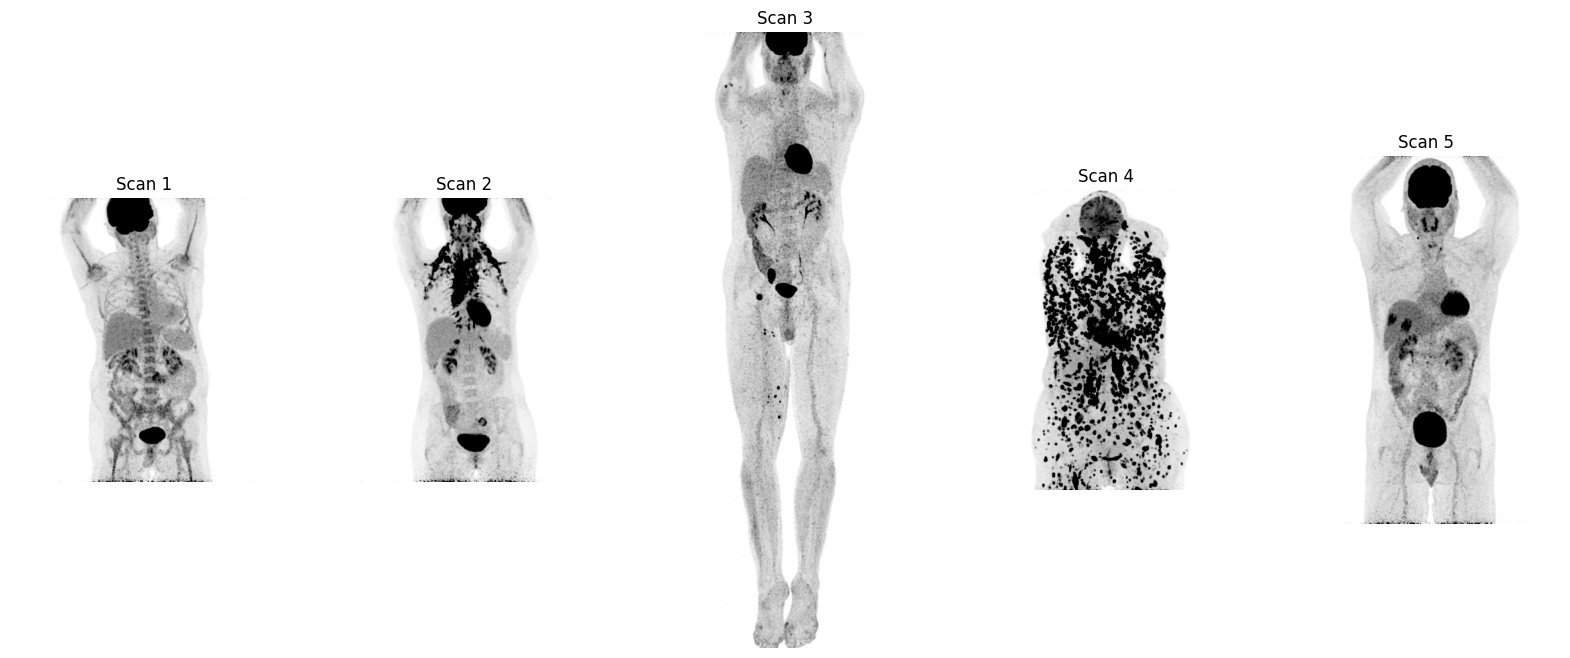

In [108]:

current_directory = os.getcwd()
print("Initial Working Directory:", current_directory)
print("Directory contents: ", os.listdir())
print("Checking existence ",os.chdir(r'/content/drive/MyDrive'))
#CHANGE TO YOUR DIRECTORY
test_path = r'/content/drive/MyDrive/data/patients/imgs'



test_files = sorted(os.listdir(test_path))[20:25]
#first to train on small number to see if all works
# Iterate over the first five files and display the images and segmentations
i = 1
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for test_file in test_files:
    test_file_path = os.path.join(test_path, test_file)

    # Load and display the image
    img = Image.open(test_file_path)
    plt.subplot(1, 5, test_files.index(test_file) + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Scan {i}')


    i +=1

plt.show()


In [109]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform

        self.test_filenames = sorted(os.listdir(test_dir))

    def __len__(self):
        return len(self.test_filenames)

    def __getitem__(self, idx):
        test_path = os.path.join(self.test_dir, self.test_filenames[idx])

        test = Image.open(test_path).convert('L')  # Convert to grayscale

        if self.transform:
            test = self.transform(test)

        return {'test': test }

def custom_collate(batch):
    # Resize images and masks to a common size
    batch_size = len(batch)
    max_height = max(item['test'].shape[1] for item in batch)
    max_width = max(item['test'].shape[2] for item in batch)

    # Pad images and masks to the maximum size
    padded_images = [torch.nn.functional.pad(item['ct_scan'], pad=(0, max_width - item['ct_scan'].shape[2], 0, max_height - item['ct_scan'].shape[1])) for item in batch]

    # Stack padded images and masks
    stacked_images = torch.stack(padded_images)

    return {'test': stacked_images}

# Define your data transformation (adjust as needed)
transform_test = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

# Define your dataset instance
test_dataset = TestDataset(test_dir=test_path, transform=transform_test)

test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

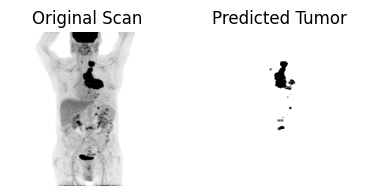

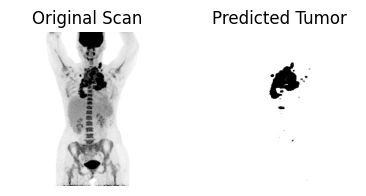

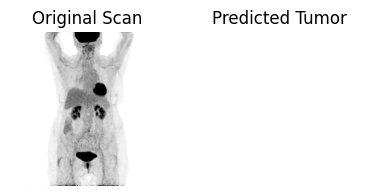

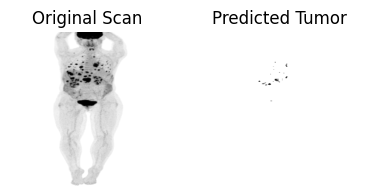

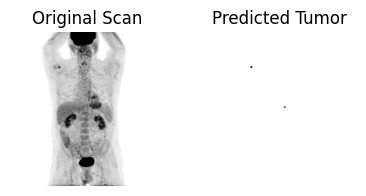

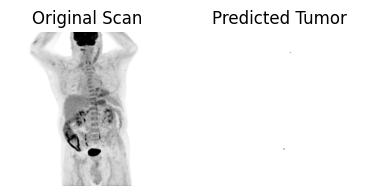

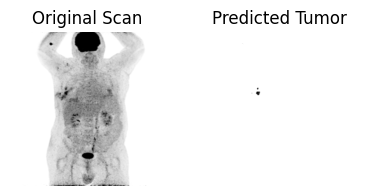

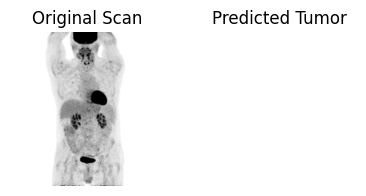

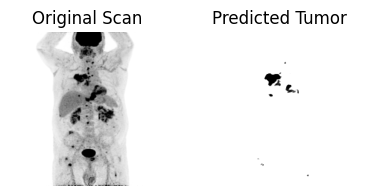

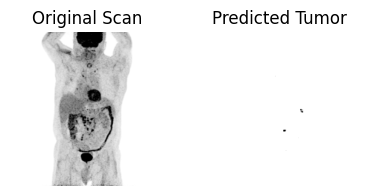

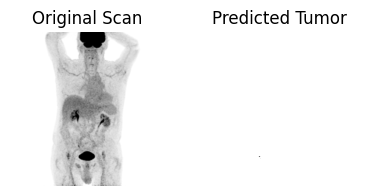

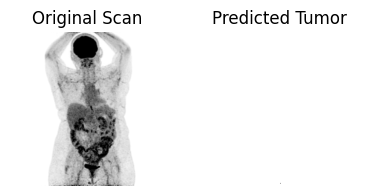

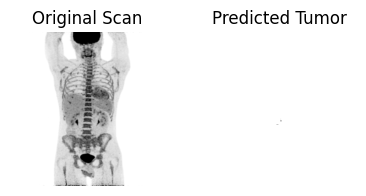

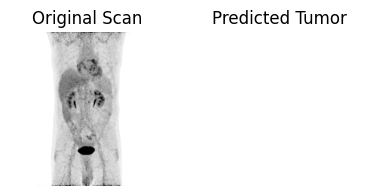

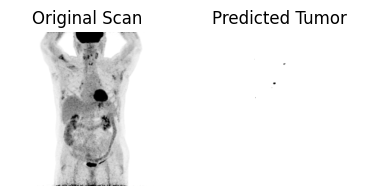

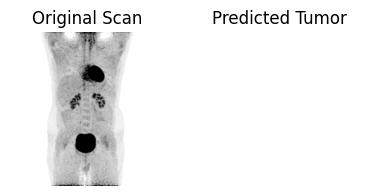

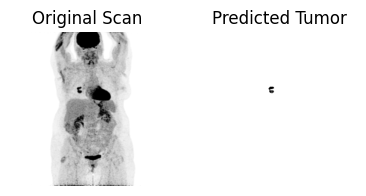

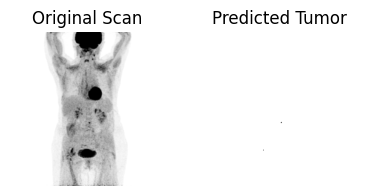

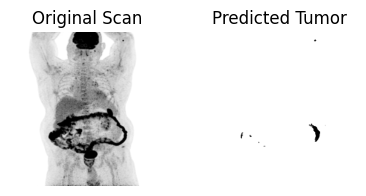

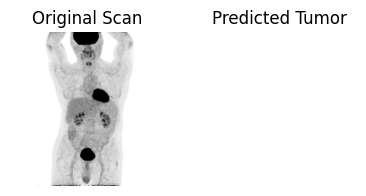

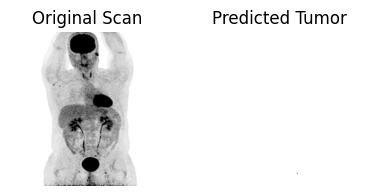

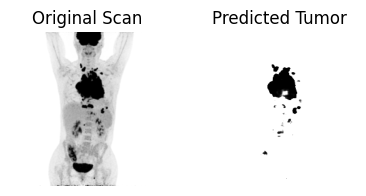

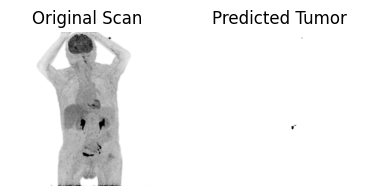

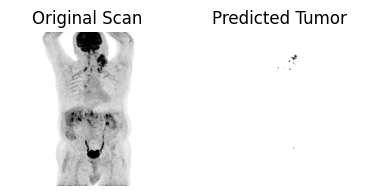

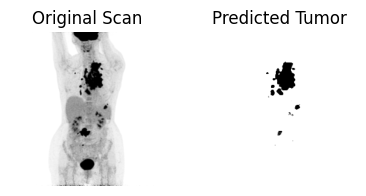

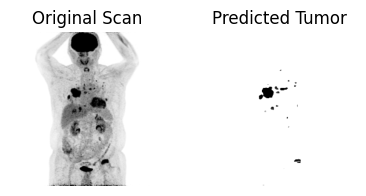

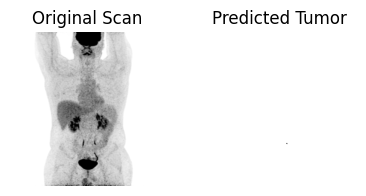

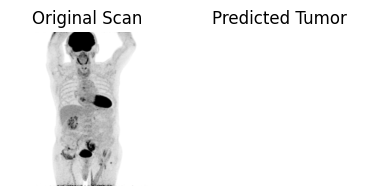

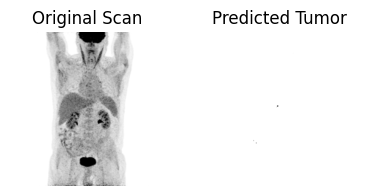

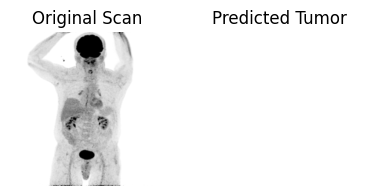

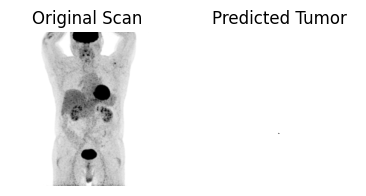

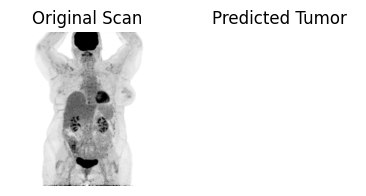

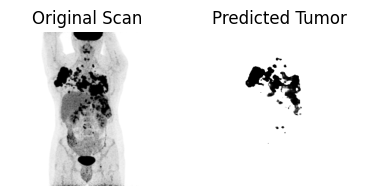

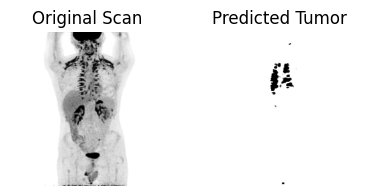

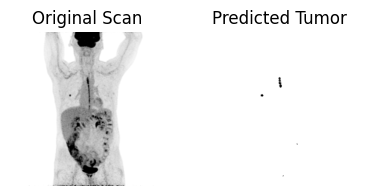

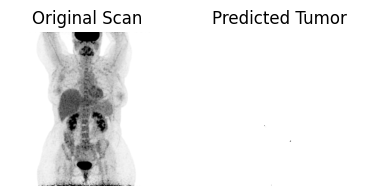

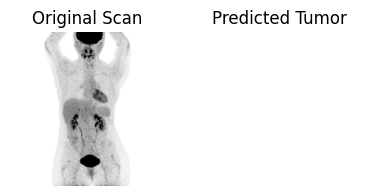

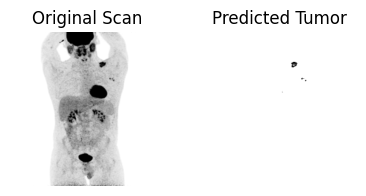

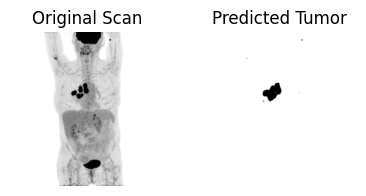

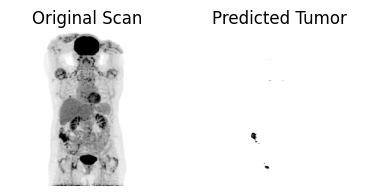

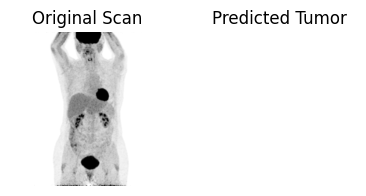

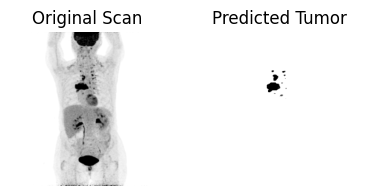

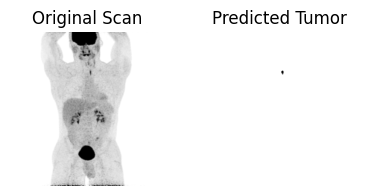

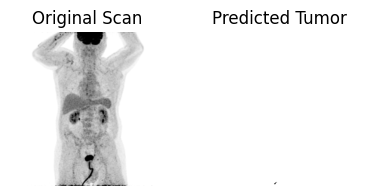

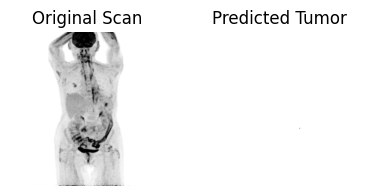

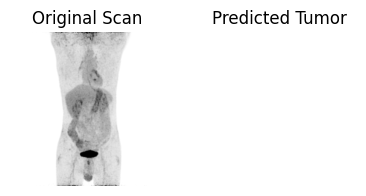

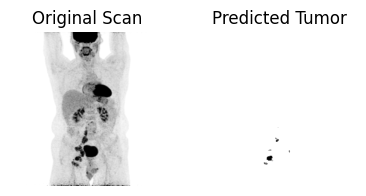

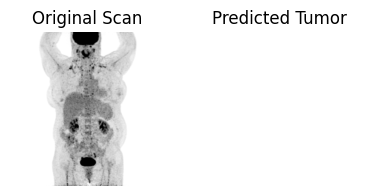

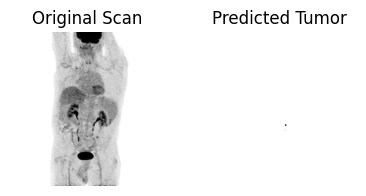

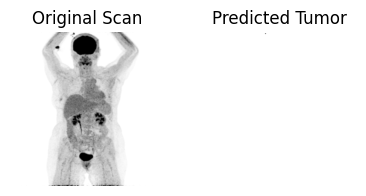

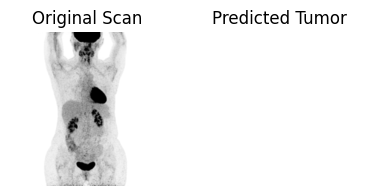

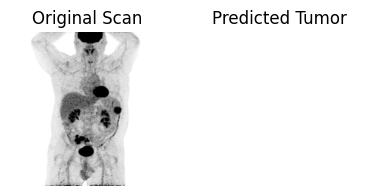

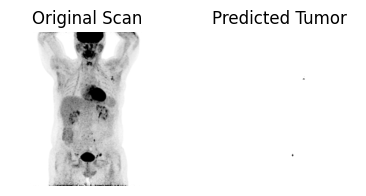

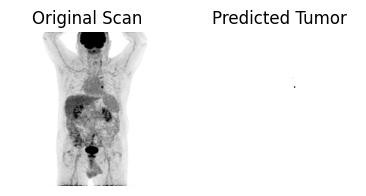

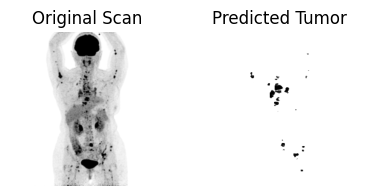

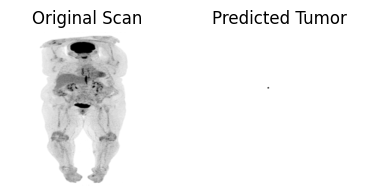

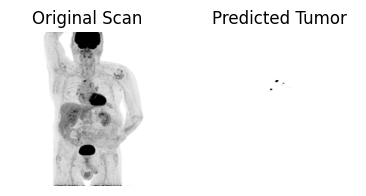

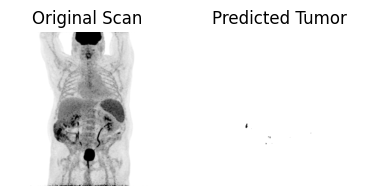

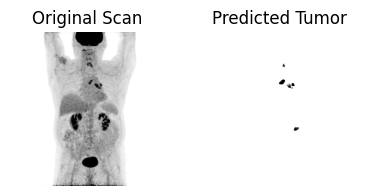

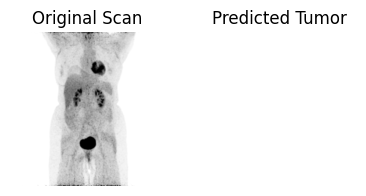

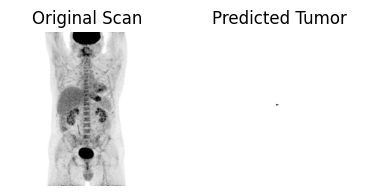

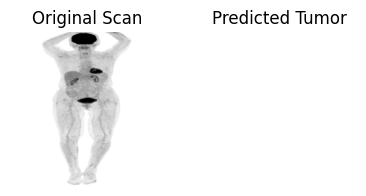

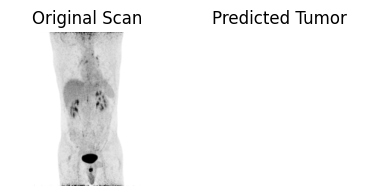

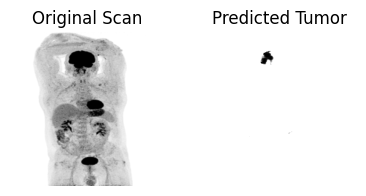

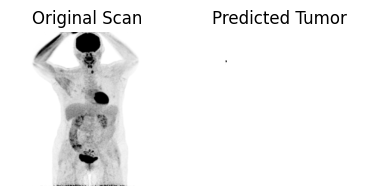

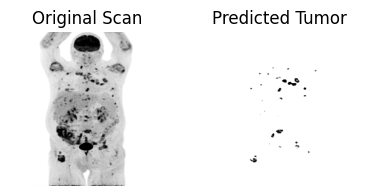

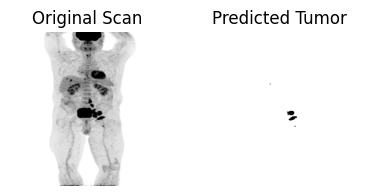

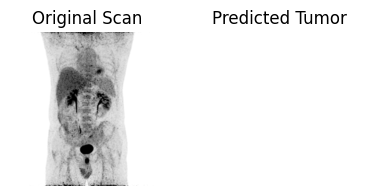

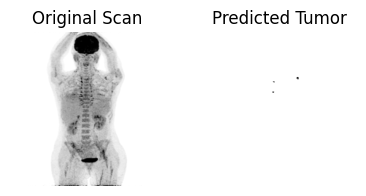

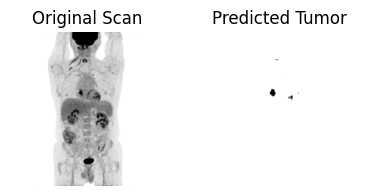

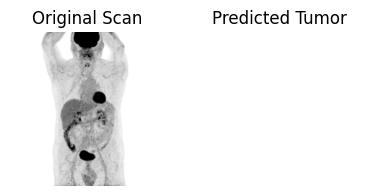

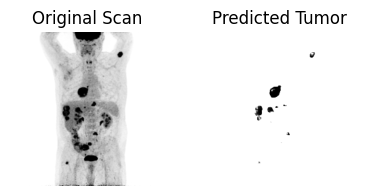

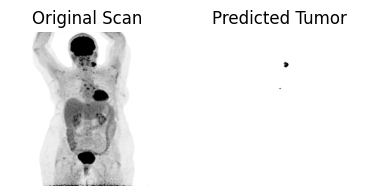

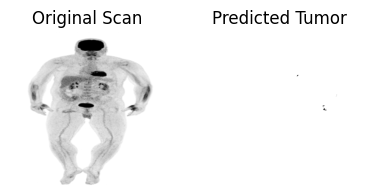

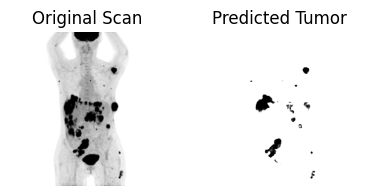

In [138]:
import matplotlib.pyplot as plt

def visualize_segmentation(model, val_dl, num_samples=5):
    model.eval()  # Set model to evaluation mode

    sample_iterator = iter(val_dl)
    for i in range(num_samples):
        data = next(sample_iterator)
        ct_scans = data['ct_scan'].to(model.device)  # Assuming your model device is set correctly

        # Forward pass
        model.ct_scan = ct_scans
        model.forward()

        # Get predicted masks (assuming you've used sigmoid activation in your model)
        predicted_masks = torch.sigmoid(model.predicted_tumor_mask).cpu().detach().numpy()

        # Convert data to numpy arrays for visualization
        ct_scan_np = ct_scans.cpu().numpy()
        for j in range(15): #len(predicted_masks)
            plt.figure(figsize=(4, 2))

            # Display the original CT scan image
            plt.subplot(1, 2, 1)
            plt.title('Original Scan')
            plt.imshow(ct_scan_np[j, 0], cmap='gray')  # Assuming grayscale CT scans
            plt.axis('off')

            # Display the predicted segmentation mask
            plt.subplot(1, 2, 2)
            plt.title('Predicted Tumor')
            #predicted_masks[j, 0] = (predicted_masks[j, 0] > 0).astype(int)
            plt.imshow(predicted_masks[j, 0], cmap='binary')  # Assuming the tumor mask is at index 1
            plt.axis('off')

            plt.tight_layout()
            plt.show()

# Usage
visualize_segmentation(model, val_dl, num_samples=5)
